# Famous Titanic dataset from Kaggle competition
* This is a fun afternoon project I ddid in R to learn the tool.
I wanted to see how effective/easy data manipulation in R is, and also how well I can do with out of the box ML library caret. 

* Introduction:
Women made a majority of Titanic survivers.And among women the young girls from the first class cabins had the best chance. 
It seems reasonable: people were invited to the safe boats based on their tickets, starting with first class passengers and also following the rule "Women and children first". However, by English tradition, 8 year old boys were not considered children, but rather young men, and that is why a lot of boys were denid the seats on the boats. 

* I wanted to see for myself if the data provides an evidence to this and also if I can find some other interesting correlations.

In [1]:
# Load packages
library(ggplot2) # visualization
library(scales) # visualization
library(dplyr) # data manipulation
library(randomForest) # classification algorithm

library(caret) #ML library
library(kernlab)
library(e1071)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

Loading required package: lattice

Attaching package: 'kernlab'

The following object is masked from 'package:scales':

    alpha

The following object is masked from 'package:ggplot2':

    alpha

Warning message:
"package 'e1071' was built under R version 3.3.3"

In [2]:
#loading data

train <- read.csv('input/train.csv', stringsAsFactors = F)
test  <- read.csv('input/test.csv', stringsAsFactors = F)
full  <- bind_rows(train, test) # bind training & test data
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


* The data contains infromation on passangers traveling with either children or parents or both (Parch) and if a passenger had a spouse or siblings (SibSp). It makes sense to use this data to generate 3 additional columns: Married_no_children, Single, and Family (one child or more) to see who had a better chance to survive.

In [3]:
full$Single <- ifelse((full$SibSp < 1 & full$Parch < 1), 1, 0)
full$Married_no_children <- ifelse((full$SibSp ==1 & full$Parch == 0), 1, 0)
full$Family <- ifelse((full$SibSp >1 & full$Single == 0 & full$Married_no_children == 0), 1, 0)

In [4]:
names(full)

[1] "PassengerId"         "Survived"            "Pclass"             
 [4] "Name"                "Sex"                 "Age"                
 [7] "SibSp"               "Parch"               "Ticket"             
[10] "Fare"                "Cabin"               "Embarked"           
[13] "Single"              "Married_no_children" "Family"

* Variables Sex, Pclass and Survived should be factor variables. It may be not so obvious for Pclass, but if you think about it... Class 3 is not "better" or "larger" than Class 1. They should be equally weighted by the algorithm. So, I am going to use one hot encoding on full dataset, to make additional columns Sexmale and Sexfemale, Pclass1, Pclass2, Pclass3. I am leaving the factor variable Sex and Pclass to simplify the EDA portion of my studdy (specifically visualisation). 

* Factorizing Survived and SibSp

* At this point I also decide to trim my parameter space. I strip it from Ticket, Embarked, Cabin, Name. Keeping the variables: PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Single, Married_no_children, Family

In [5]:
full<-with(full,data.frame(PassengerId, Survived, Pclass, Sex, model.matrix(~Sex-1,full),
                  Age, SibSp, Parch, Single, Married_no_children, Fare, Family))

full$Pclass <-factor(full$Pclass)
full<-with(full,data.frame(PassengerId, Survived, Pclass, model.matrix(~Pclass-1,full),
                  Sex, Sexmale, Sexfemale, Age, SibSp, Parch, Single, Married_no_children, Fare, Family))

full$Survived <- factor(full$Survived)
full$SibSp <- factor(full$SibSp)

str(full)

'data.frame':	1309 obs. of  16 variables:
 $ PassengerId        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived           : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass             : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Pclass1            : num  0 1 0 1 0 0 1 0 0 0 ...
 $ Pclass2            : num  0 0 0 0 0 0 0 0 0 1 ...
 $ Pclass3            : num  1 0 1 0 1 1 0 1 1 0 ...
 $ Sex                : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Sexmale            : num  1 0 0 0 1 1 1 1 0 0 ...
 $ Sexfemale          : num  0 1 1 1 0 0 0 0 1 1 ...
 $ Age                : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp              : Factor w/ 7 levels "0","1","2","3",..: 2 2 1 2 1 1 1 4 1 2 ...
 $ Parch              : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Single             : num  0 0 1 0 1 1 1 0 0 0 ...
 $ Married_no_children: num  1 1 0 1 0 0 0 0 0 1 ...
 $ Fare               : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Family             : num  0 0

In [6]:
length(unique(train$PassengerId))
length(unique(test$PassengerId))
(length(unique(train$PassengerId)) + length(unique(test$PassengerId))) == length(unique(full$PassengerId))

[1] 891

[1] 418

[1] TRUE

I will take 100 data points from train set to make it my validation set to run ML

In [7]:
train <- full[1:791,]
length(unique(train$PassengerId))
test <- full[892:1309,]
length(unique(test$PassengerId))
valid <- full[792:891,]
length(unique(valid$PassengerId))
length(unique(train$PassengerId))+length(unique(test$PassengerId))+length(unique(valid$PassengerId))

[1] 791

[1] 418

[1] 100

[1] 1309

## EXPLARATORY DATA ANALYSIS

* Here is the summary of the pasengers who survived and those who perished based on information from the train set. Numbers are telling the story, but visualisation is still very helpful

In [8]:
by(train, train$Survived, summary)

train$Survived: 0
  PassengerId    Survived Pclass     Pclass1          Pclass2      
 Min.   :  1.0   0:485    1: 74   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:181.0   1:  0    2: 84   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :399.0            3:327   Median :0.0000   Median :0.0000  
 Mean   :395.1                    Mean   :0.1526   Mean   :0.1732  
 3rd Qu.:599.0                    3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :791.0                    Max.   :1.0000   Max.   :1.0000  
                                                                   
    Pclass3           Sex         Sexmale         Sexfemale     
 Min.   :0.0000   female: 70   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   male  :415   1st Qu.:1.0000   1st Qu.:0.0000  
 Median :1.0000                Median :1.0000   Median :0.0000  
 Mean   :0.6742                Mean   :0.8557   Mean   :0.1443  
 3rd Qu.:1.0000                3rd Qu.:1.0000   3rd Qu.:0.0000  
 Max.   :1.0000                Max.   :1.0000   

## How many males vs females traveled on Titanic? Who survived?

In [9]:
unique(full$Sex)
aggregate(data.frame(count = full$Sex), list(value = full$Sex), length)

[1] male   female
Levels: female male

value,count
female,466
male,843


Yes, women had a much better chance to survive. 

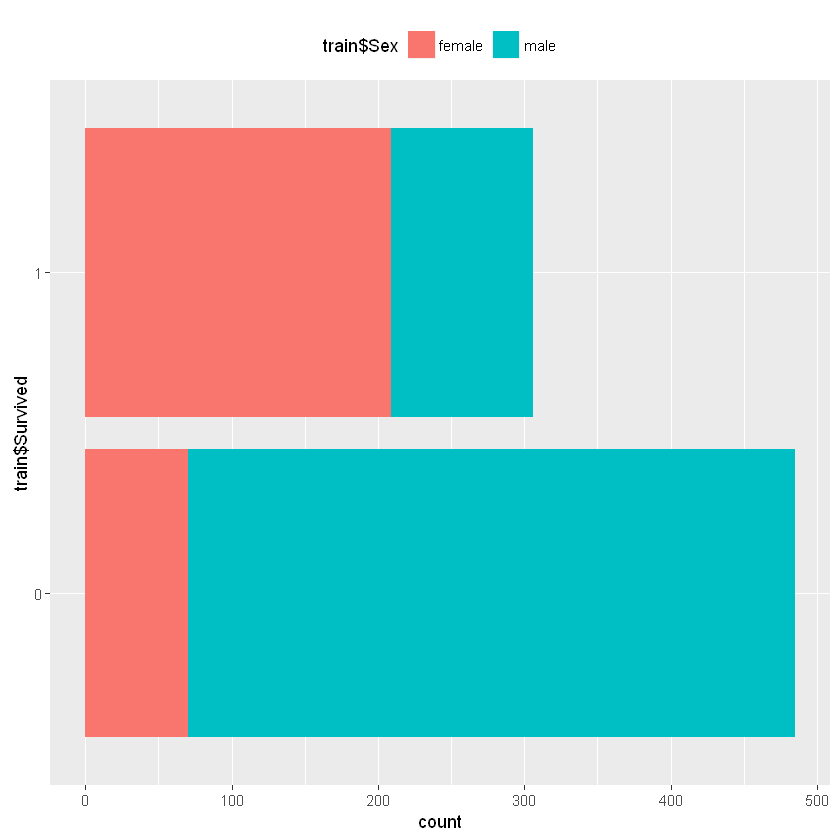

In [10]:
ggplot(train, aes(train$Survived)) +
    geom_bar(aes(fill = train$Sex)) +
    coord_flip() +
    theme(legend.position = "top")

### But how is female population different from male's? Were they older? Were they married? Were they richer?
* Yes, they payed in average higher price for the tickets (richer)
* No, they were approximatly same age as men, even slightly younger.
* Yes, there is a difference in status - only 1/2 of women were single, compare to 3/4 of men.


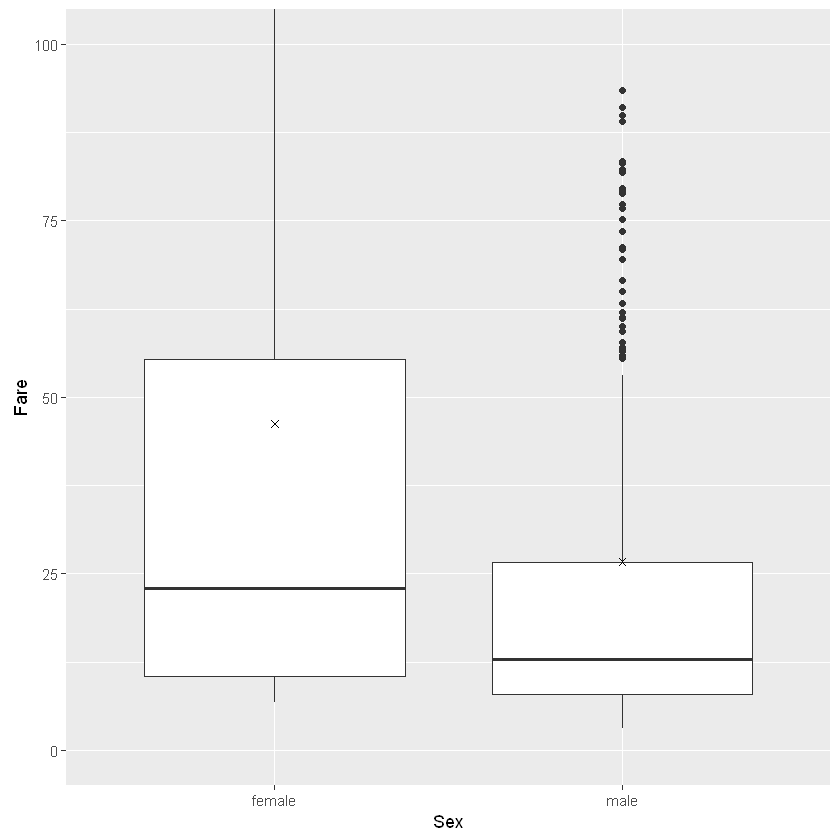

In [11]:
ggplot(aes(x = Sex, y = Fare), data = subset(full, (!is.na(full$Fare) & full$Fare != 0.0))) +
    geom_boxplot() +
    stat_summary(fun.y = mean, geom = 'point', shape = 4) + 
    coord_cartesian(ylim = c(0,100))

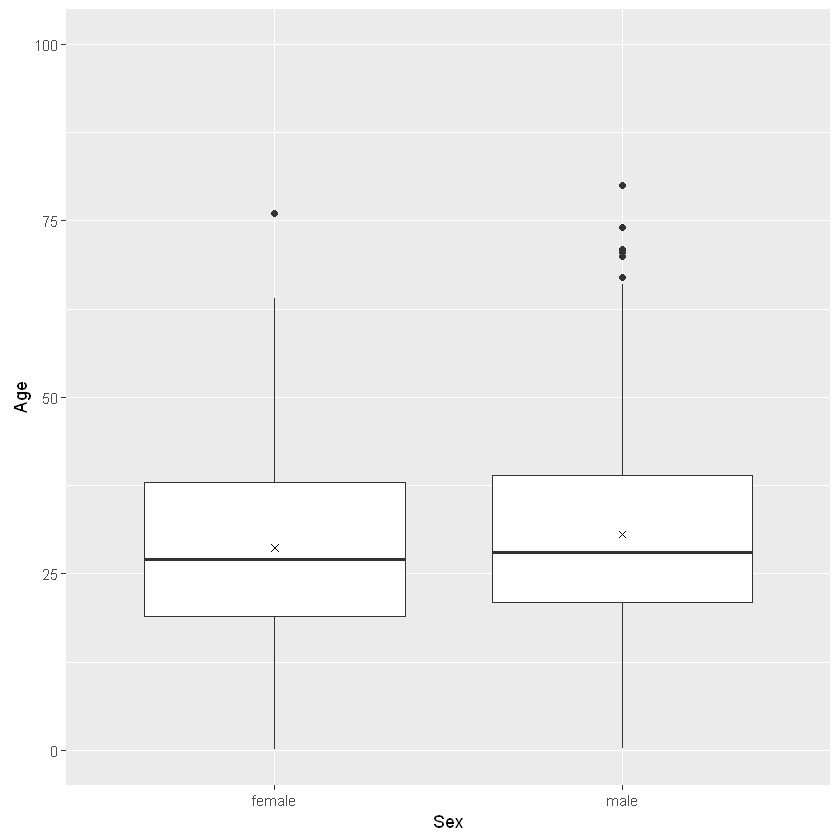

In [12]:
ggplot(aes(x = Sex, y = Age), data = subset(full, (!is.na(full$Age) & full$Age != 0.0))) +
    geom_boxplot() +
    stat_summary(fun.y = mean, geom = 'point', shape = 4) + 
    coord_cartesian(ylim = c(0,100))

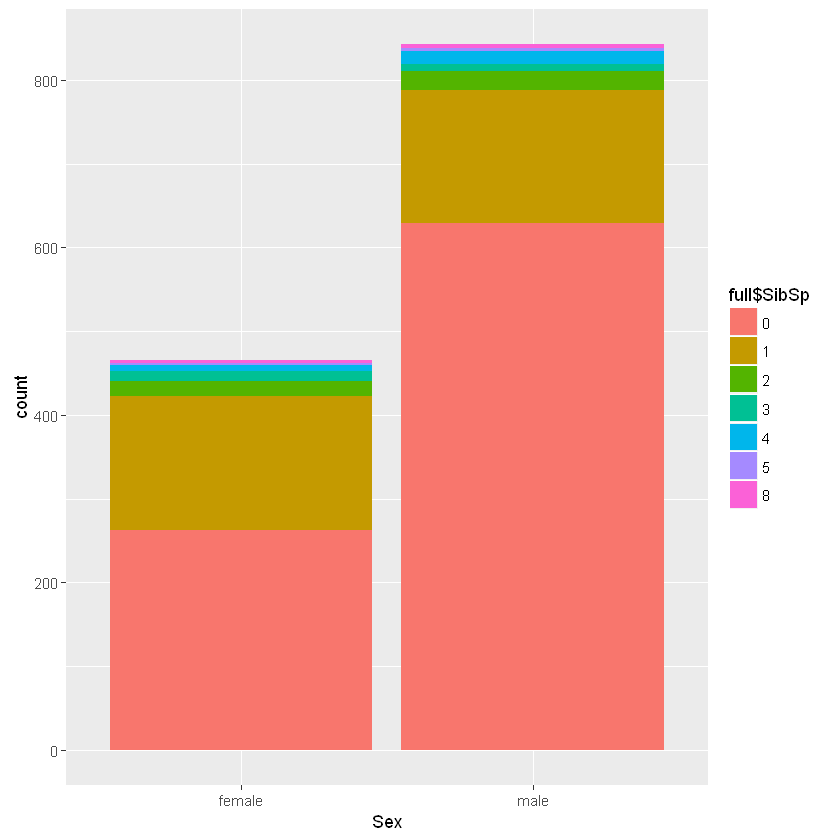

In [13]:
ggplot(aes(Sex), data = full) +
    geom_bar(aes(fill = full$SibSp))
    


### Now, let's look who survived based on Fare and size of the family basis?
* Those who paid more for the ticket had a better chance to survive
* Large family didn't survived - SibSp>5 (hmmmm...)
* Singles had smaller chance to survived too. I wonder why?

No summary function supplied, defaulting to `mean_se()


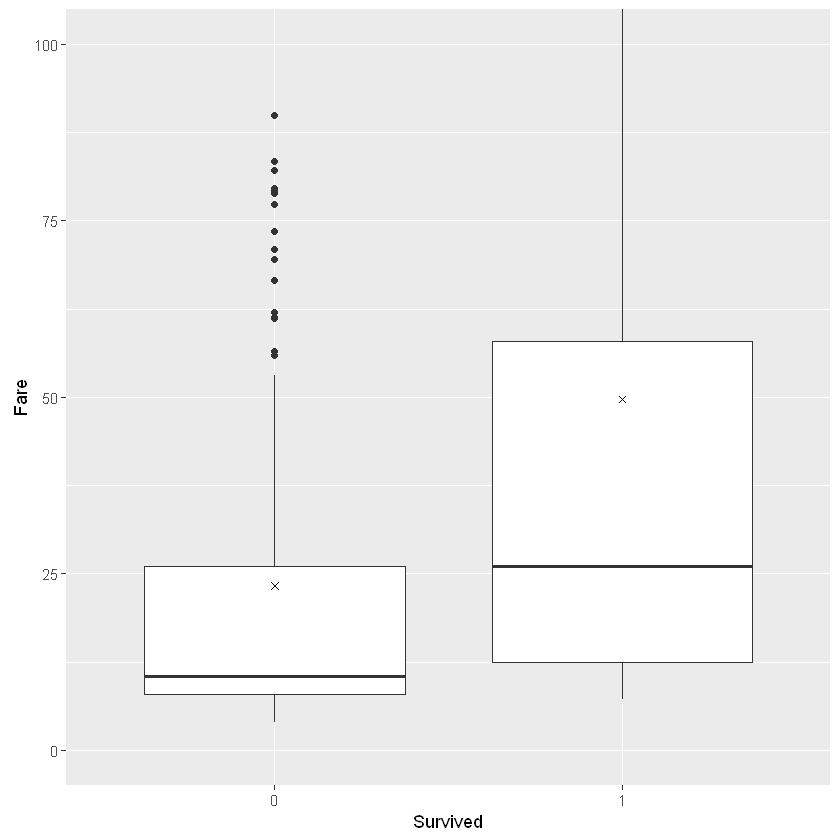

In [14]:
train$Survived <- factor(train$Survived)
ggplot(aes(x = Survived, y = Fare), data = subset(train, (!is.na(train$Fare) & train$Fare != 0.0))) +
    geom_boxplot() +
    stat_summary(geom = 'point', shape = 4) + 
    coord_cartesian(ylim = c(0,100))



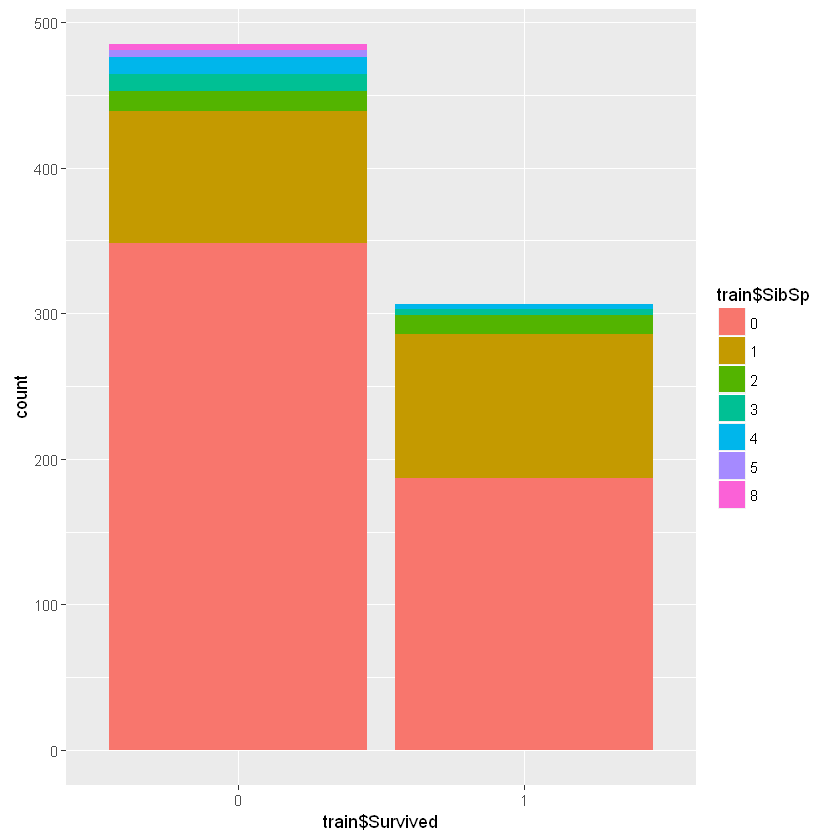

In [15]:
#need to factorize SibSp to plot in colors
train$SibSp <- factor(train$SibSp)
ggplot(aes(train$Survived), data = train) +
    geom_bar(aes(fill = train$SibSp))

### Did those large families perished because they were residing in 3rd class? Let's see how much those family payed for their tickets and what class did they travel...
* Yes... seems like 3/4 of families with children traveled in 3rd class. May be that is the reason they didn't survived.

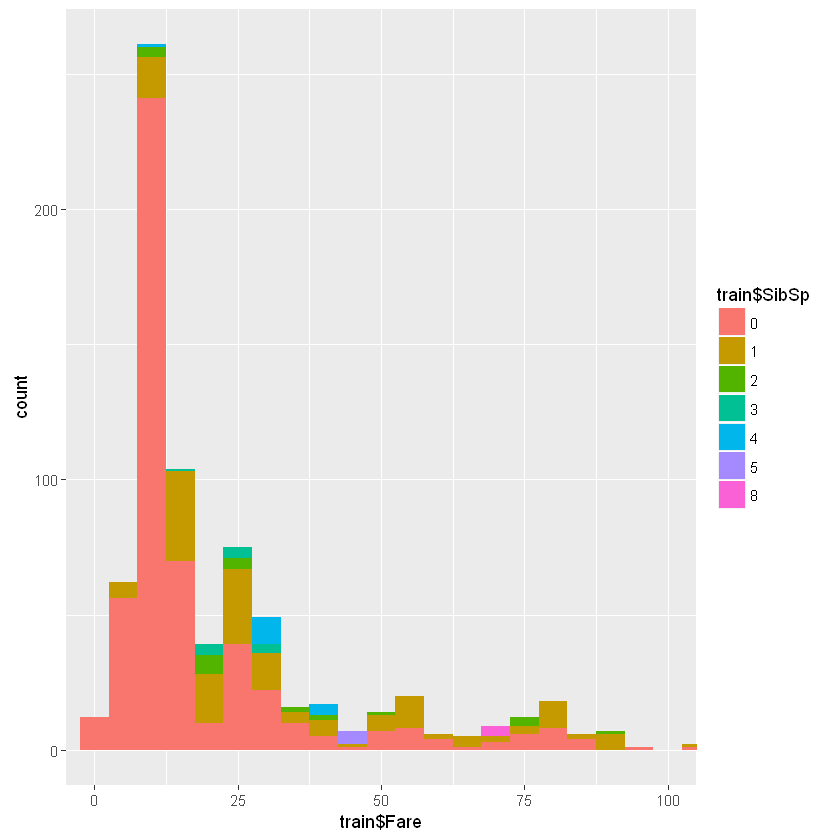

In [16]:
ggplot(train, aes(train$Fare, fill = train$SibSp)) + 
    geom_histogram(binwidth = 5) +
    coord_cartesian(xlim = c(0,100))

In [17]:
train.by_class <- train %>%
    group_by(Pclass,Family) %>%
    summarise(n=n()) %>%
    ungroup() %>%
    arrange(Pclass)
length(subset(train, train$Family == 1)$Family)
summary(train.by_class)
train.by_class


[1] 66

 Pclass     Family          n        
 1:2    Min.   :0.0   Min.   :  8.0  
 2:2    1st Qu.:0.0   1st Qu.: 19.0  
 3:2    Median :0.5   Median :102.0  
        Mean   :0.5   Mean   :131.8  
        3rd Qu.:1.0   3rd Qu.:177.5  
        Max.   :1.0   Max.   :385.0  

Pclass,Family,n
1,0,185
1,1,8
2,0,155
2,1,9
3,0,385
3,1,49


In [18]:
#is.factor(as.numeric(levels(train$SibSp))[train$SibSp])

### Now, back to the question, what happened to the boys? Is it true that around age 8 the boys are not survivers anymore?
Since the number of males are much larger than femails I will look at the PART of SURVIVED/PERISHED for both genders as a function of age.

It'd be nice to plot these data, and I will do it some other time. Now I am just comparing the survival rate of male vs female at different ages

*  <10 y/o
girls  3.6,
boys 1.5

* <12 y/o
girls  1.7,
boys 1.2

* <16 y/o
girls  2,
boys 1

* <18 y/o
girls  2.3,
boys 0.6

There is a clear drop in survival rate for boys around 18 y/o, but not 8! **Myth is busted.**
Still not quite clear why girls have been luckier

In [19]:
summary(train$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.67   21.00   28.00   29.85   38.00   80.00     161 

In [20]:
train$Survived <- factor(train$Survived)
train.age_subset <- subset(train, (!is.na(train$Age) & train$Age<8))
#Need to find %survivals in girls and %survvals in boys
girls_survived <- subset(train.age_subset, (train.age_subset$Sex == 'female' & train.age_subset$Survived == 1))
girls_perished <- subset(train.age_subset, (train.age_subset$Sex == 'female' & train.age_subset$Survived == 0))
length(girls_survived$PassengerId)/length(girls_perished$PassengerId)

boys_survived <- subset(train.age_subset, (train.age_subset$Sex == 'male' & train.age_subset$Survived == 1))
boys_perished <- subset(train.age_subset, (train.age_subset$Sex == 'male' & train.age_subset$Survived == 0))
length(unique(boys_survived$PassengerId))/length(unique(boys_perished$PassengerId))
length(unique(train.age_subset$PassengerId))

[1] 3.6

[1] 1.5

[1] 43

## EDA summary: 
* Women had much better chance to survive the catastroph. Makes sense since they travel on average in slightly more expensive cabins and were allowed on the safe boats before cheap 3rd class. Also, the rule: "Women and children first", obviously helped.

* It is a myth that boys older than 8 were not allowed on boats, seems like the cutoff age was somwhere between 16 and 18. 

* Large families didn't survive, singles also had a smaller chance to get out alive. Could be partially due to the fact that both categories traveled in inexpensive cabines, further from the acess to the life boats.

## MACHINE LEARNING

In [21]:
#Converting factor variables back to numeric

train$SibSp <- as.numeric(levels(train$SibSp))[train$SibSp]
train$Survived<- as.numeric(levels(train$Survived))[train$Survived]
train$Pclass<- as.numeric(levels(train$Pclass))[train$Pclass]
str(train)

'data.frame':	791 obs. of  16 variables:
 $ PassengerId        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived           : num  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass             : num  3 1 3 1 3 3 1 3 3 2 ...
 $ Pclass1            : num  0 1 0 1 0 0 1 0 0 0 ...
 $ Pclass2            : num  0 0 0 0 0 0 0 0 0 1 ...
 $ Pclass3            : num  1 0 1 0 1 1 0 1 1 0 ...
 $ Sex                : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Sexmale            : num  1 0 0 0 1 1 1 1 0 0 ...
 $ Sexfemale          : num  0 1 1 1 0 0 0 0 1 1 ...
 $ Age                : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp              : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch              : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Single             : num  0 0 1 0 1 1 1 0 0 0 ...
 $ Married_no_children: num  1 1 0 1 0 0 0 0 0 1 ...
 $ Fare               : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Family             : num  0 0 0 0 0 0 0 1 0 0 ...


### Let's see what variables are contributing the most into the desision. 

* For this pupropse I will use Decision Tree (RandomForest aggregation to be precised) algorithm to see how it gets splits based on the information enthropy. 
* One important thing to remember - Decision Tree does not work with NA. Menas my training set should contain values in every raw and every column.
Let's do this

In [22]:
x_train <- train[complete.cases(train$Age), ]

In [23]:
set.seed(754)

# Build the model (note: not all possible variables are used)
rf_model <- randomForest(factor(Survived) ~ Sexfemale + Sexmale + Age + Fare + SibSp +Parch + Family + Single + Married_no_children + Pclass1 +Pclass2 +Pclass3, data =x_train)
rf_model



Call:
 randomForest(formula = factor(Survived) ~ Sexfemale + Sexmale +      Age + Fare + SibSp + Parch + Family + Single + Married_no_children +      Pclass1 + Pclass2 + Pclass3, data = x_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 18.89%
Confusion matrix:
    0   1 class.error
0 340  33  0.08847185
1  86 171  0.33463035

In [24]:
importance    <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))

In [25]:
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

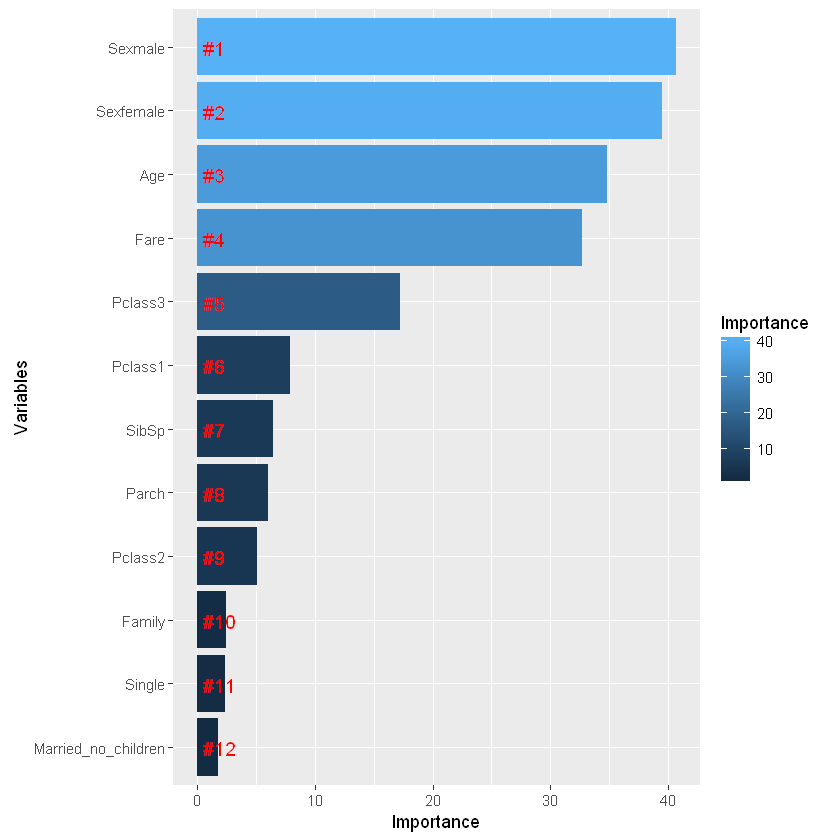

In [26]:
# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
    y = Importance, fill = Importance)) +
    geom_bar(stat='identity') + 
    geom_text(aes(x = Variables, y = 0.5, label = Rank),
    hjust=0, vjust=0.55, size = 4, colour = 'red') +
    labs(x = 'Variables') +
    coord_flip()

* Very well, seems like neither one of my newly introduced variables (Single, Family, Married_no_children) really contribute into the classification 
* What is important that Age is one of the pretty important factors. Means we cannot ommit this parameter. 2 ways to prceed: use the algorithm that doesnt' care about NA (NaiveBayes) or somehow make sure we fill out all the blankes for Age parameter.
* (I tryed Naive Bayes which gave me a quite sad accuracy of 75%. This is not good enough, so we need to get the Age data in order)
* I am going to use Machine Learning first to predict missing Age based on available parameters. Let's print a correlation matrix to see what our best candidates for age prediction are.
    

,Sexmale,Sexfemale,Age,Pclass,Parch,Single,SibSp
1,1,0,22,3,0,0,1
2,0,1,38,1,0,0,1
3,0,1,26,3,0,1,0
4,0,1,35,1,0,0,1
5,1,0,35,3,0,1,0
7,1,0,54,1,0,1,0


,Sexmale,Sexfemale,Age,Pclass,Parch,Single,SibSp
Sexmale,1.0000000,-1.0000000,0.1244799,0.1421036,-0.2450860,0.2623235,-0.1050287
Sexfemale,-1.0000000,1.0000000,-0.1244799,-0.1421036,0.2450860,-0.2623235,0.1050287
Age,0.1244799,-0.1244799,1.0000000,-0.3715187,-0.1825574,0.1922030,-0.3071295
Pclass,0.1421036,-0.1421036,-0.3715187,1.0000000,0.0248318,0.1488041,0.0679711
Parch,-0.2450860,0.2450860,-0.1825574,0.0248318,1.0000000,-0.5669714,0.3835855
Single,0.2623235,-0.2623235,0.1922030,0.1488041,-0.5669714,1.0000000,-0.6340517
SibSp,-0.1050287,0.1050287,-0.3071295,0.0679711,0.3835855,-0.6340517,1.0000000


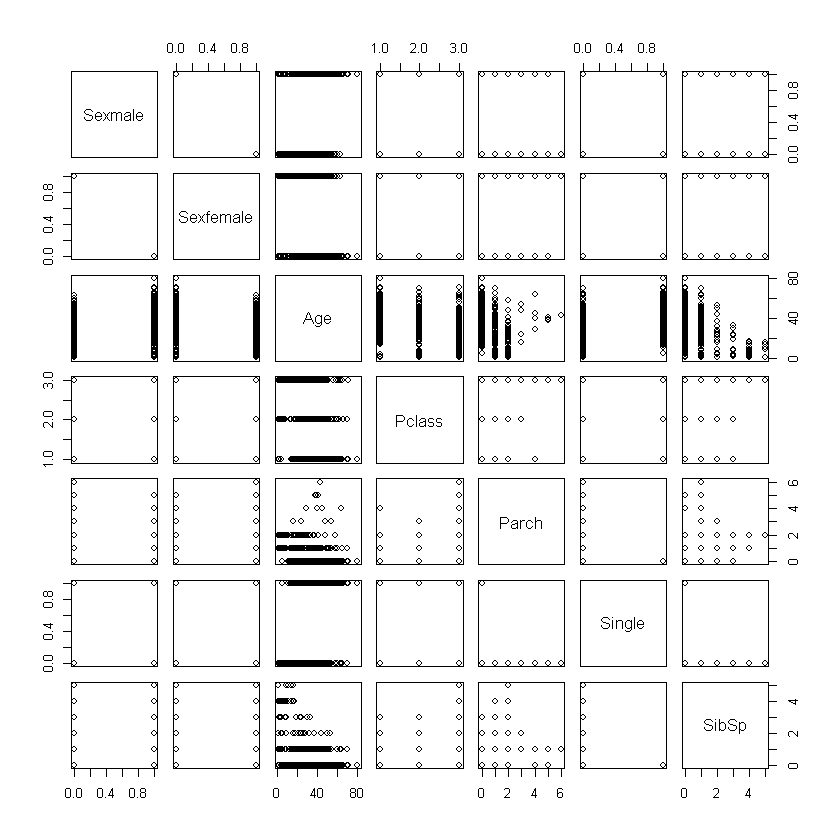

In [27]:
new_train = subset(train, select = c(Sexmale, Sexfemale, Age, Pclass, Parch, Single, SibSp))
new_train_new <- new_train[complete.cases(new_train),]     
head(new_train_new)
cov.matr = cov(new_train_new)
cov2cor(cov.matr)
pairs(new_train_new)

In [28]:
cor.test(train$Age, train$SibSp)


	Pearson's product-moment correlation

data:  train$Age and train$SibSp
t = -8.0875, df = 628, p-value = 3.147e-15
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3762176 -0.2346449
sample estimates:
       cor 
-0.3071295 


In [29]:
cor.test(train$Age, train$Parch)


	Pearson's product-moment correlation

data:  train$Age and train$Parch
t = -4.6531, df = 628, p-value = 3.991e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2570064 -0.1059544
sample estimates:
       cor 
-0.1825574 


In [30]:
cor.test(train$Age, train$Pclass)


	Pearson's product-moment correlation

data:  train$Age and train$Pclass
t = -10.028, df = 628, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4369520 -0.3021741
sample estimates:
       cor 
-0.3715187 


* Based on the correlation test seems like Age has the strongest correlion with SibSp (spouse, siblings), then Parch (parents, children), but also travel accomodations Pclass. 
* I will use 4 parameters (Single, SibSp, Parch, Pclass to predict missing age) . 

In [31]:
# Create 2 data frames with Age data in missing
#and Age data in place
#Attention! I am using full dataframe since I am not interested in the Survived numbers, but Age

no_full <- full[is.na(full$Age),]
length(no_full$Age)

yes_full <- full[complete.cases(full$Age),]  
length(yes_full$Age)


[1] 263

[1] 1046

In [32]:
#train algorithm using data with Age available

control <- trainControl(method="cv", number=10)
set.seed(7)
fit <- train(Age ~ (Pclass1 + Pclass2 + Pclass3 +Single+SibSp +Parch), data = yes_full, method="svmRadial", trControl=control)


fit

Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."

Support Vector Machines with Radial Basis Function Kernel 

1046 samples
   6 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 940, 942, 941, 942, 942, 942, ... 
Resampling results across tuning parameters:

  C     RMSE      Rsquared 
  0.25  12.72093  0.2466751
  0.50  12.66094  0.2522949
  1.00  12.58688  0.2609131

Tuning parameter 'sigma' was held constant at a value of 0.06311676
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were sigma = 0.06311676 and C = 1. 

In [33]:
# Populating Age column by predictions
results <- predict(fit, no_full)
length(results)
no_full$Age <- results

[1] 263

In [34]:
#concatinating two dataframes yes and no_full and ordering it by PassengerId
full  <- bind_rows(no_full, yes_full)
length(full$Age)

full <- full[with(full, order(PassengerId)), ]

[1] 1309

In [35]:
#Separate data again on train, test and valid

train <- full[1:791,]
length(unique(train$PassengerId))
test <- full[892:1309,]
length(unique(test$PassengerId))
valid <- full[792:891,]
length(unique(valid$PassengerId))
length(unique(train$PassengerId))+length(unique(test$PassengerId))+length(unique(valid$PassengerId))

[1] 791

[1] 418

[1] 100

[1] 1309

In [36]:
# Run SVM
set.seed(7)
control <- trainControl(method="cv", number=10)
metric <- "Accuracy"
str(train)
# Build the model (note: not all possible variables are used)
fit <- train(factor(Survived) ~ (Sexmale + Sexfemale + Age +  Pclass3), data = train,method="svmRadial", trControl=control)
# c) advanced algorithms

fit

'data.frame':	791 obs. of  16 variables:
 $ PassengerId        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived           : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass             : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Pclass1            : num  0 1 0 1 0 0 1 0 0 0 ...
 $ Pclass2            : num  0 0 0 0 0 0 0 0 0 1 ...
 $ Pclass3            : num  1 0 1 0 1 1 0 1 1 0 ...
 $ Sex                : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Sexmale            : num  1 0 0 0 1 1 1 1 0 0 ...
 $ Sexfemale          : num  0 1 1 1 0 0 0 0 1 1 ...
 $ Age                : num  22 38 26 35 35 ...
 $ SibSp              : Factor w/ 7 levels "0","1","2","3",..: 2 2 1 2 1 1 1 4 1 2 ...
 $ Parch              : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Single             : num  0 0 1 0 1 1 1 0 0 0 ...
 $ Married_no_children: num  1 1 0 1 0 0 0 0 0 1 ...
 $ Fare               : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Family             : num  0 0 0 0 0 0 0 1 0 

Support Vector Machines with Radial Basis Function Kernel 

791 samples
  4 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 711, 711, 712, 712, 713, 713, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.8079410  0.5795913
  0.50  0.8167868  0.5991659
  1.00  0.8192868  0.6038222

Tuning parameter 'sigma' was held constant at a value of 1.429841
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were sigma = 1.429841 and C = 1. 

In [37]:
results <- predict(fit, valid)
length(results)
summary(results)
confusionMatrix(data = results, reference = valid$Survived)

[1] 100

0  1 
72 28

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 59 13
         1  5 23
                                          
               Accuracy : 0.82            
                 95% CI : (0.7305, 0.8897)
    No Information Rate : 0.64            
    P-Value [Acc > NIR] : 6.433e-05       
                                          
                  Kappa : 0.5894          
 Mcnemar's Test P-Value : 0.09896         
                                          
            Sensitivity : 0.9219          
            Specificity : 0.6389          
         Pos Pred Value : 0.8194          
         Neg Pred Value : 0.8214          
             Prevalence : 0.6400          
         Detection Rate : 0.5900          
   Detection Prevalence : 0.7200          
      Balanced Accuracy : 0.7804          
                                          
       'Positive' Class : 0               
                                          

### Accuracy is > 80% on a validation set.

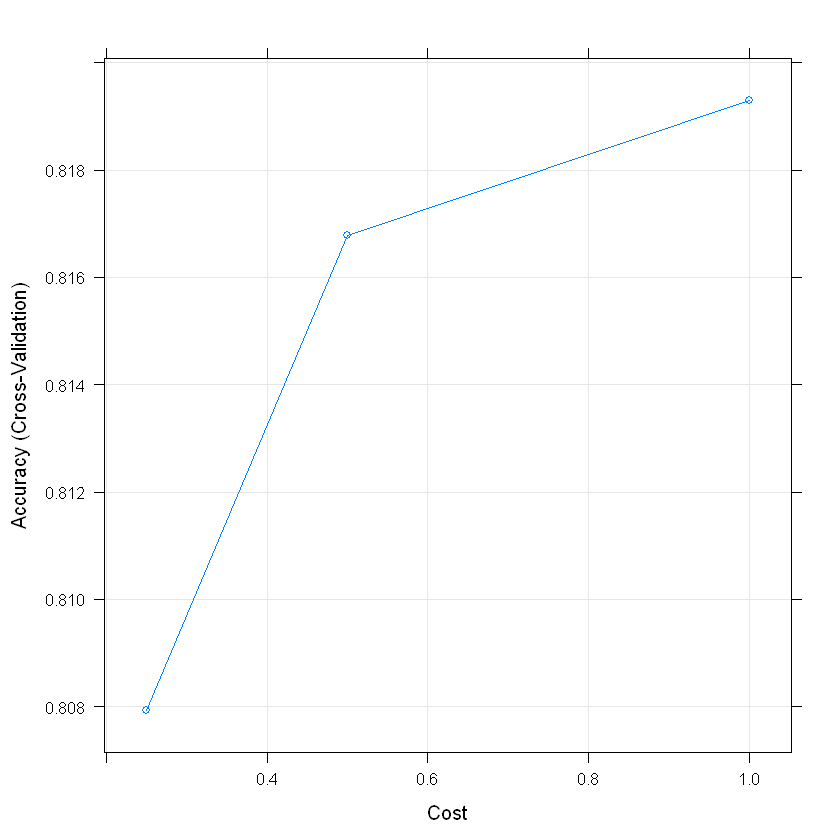

In [38]:
plot(fit)

In [39]:
#making prediction on test set

results <- predict(fit, test)
length(results)
length(test$Sex)

[1] 418

[1] 418

In [40]:
#Saving solution
solution <- data.frame(PassengerID = test$PassengerId, Survived = results)

# Write the solution to file
write.csv(solution, file = 'SVM-Solution.csv',  row.names = F)

## Reported Kaggle ranking Top 43%
* Note: SVM algorithm works the best ewhen data is normalized (mean = 0 std = 1) I triyed that too using scale() function on all the columns except Survived. Didn't really make any difference in prediction Accuracy.